In [ ]:
# Konlpy 설치
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

In [ ]:
import numpy as np
import os
import json
import nltk
import os.path 
import pandas as pd
import matplotlib.pyplot as plt
import re
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt
%matplotlib inline

# 데이터 로드

In [ ]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


# 데이터 정제


In [ ]:
# train_data에 혹시 데이터에 중복이 있지는 않은지 확인
train_data['document'].nunique(), train_data['label'].nunique() # 150000개중 146182개 남음 중복 약 3900개

(146182, 2)

In [ ]:
# 중복된 샘플 제거 후 확인
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


In [ ]:
# 긍정 부정 샘플의 비율 확인
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [ ]:
# null 값 가진 샘플을 찾는다.
print(train_data.isnull().values.any()) # True면 null 값이 있다는것

True


In [ ]:
print(train_data.isnull().sum()) # 컬럼별로 합계를 구해 어디에 null이 존재하는지 확인

id          0
document    1
label       0
dtype: int64


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인  Flase면 null 없는거

False


# 한글과 공백제외 전부 삭제.

In [ ]:
# 정규화 이용해 진행.
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #ㄱ ~ ㅎ 엔 초성들 포함, ㅏ ~ ㅣ엔 ㅠ 포함.

In [ ]:
# 한글과 공백 제외 전부 삭제를 하였기 때문에 한글이 없던 리뷰는 ""가 되었을 것. 
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum()) # 789개의 null

id            0
document    789
label         0
dtype: int64


In [ ]:
# # Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')

# test데이터도 동일하게 진행

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


# 문장 토큰화후 Json 저장.

이미 만들어진 형태소


In [ ]:
# 불용어 선언
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### okt.morphs(sentence, stem=True) 사용

In [ ]:
# train데이터 토큰화
okt = Okt()
X_train = []

len_sentence = len(train_data['document'])
for idx, sentence in enumerate(train_data['document']):
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

    if idx % (len_sentence // 100) == 0: # 진행률 궁금해서 저장했음
            print("진행률 : {}%".format(idx // (len_sentence // 100)))

with open('./data/morphs_use_train.json', 'w', encoding='utf-8') as make_file:
    json.dump(X_train, make_file, ensure_ascii=False, indent='\t')

In [ ]:
# test데이터 토큰화 
X_test = []

len_sentence = len(test_data['document'])
for idx, sentence in enumerate(test_data['document']):
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

    if idx % (len_sentence // 100) == 0: # 진행률 궁금해서 저장했음
            print("진행률 : {}%".format(idx // (len_sentence // 100)))

with open('./data/morphs_use_test.json', 'w', encoding='utf-8') as make_file:
    json.dump(X_test, make_file, ensure_ascii=False, indent='\t')

#### okt.pos(sentence, norm=True, stem=True) 사용
- ## **okt.morphs()에 비해서 성능이 별로라 사용안함.(전처리등 조건이 전부 동일할 때 성능차이가 있었음)**

In [ ]:
# 이제 사용안하는 부분.

okt = Okt()
X_train = []
len_sentence = len(train_data['document'])

for idx, sentence in enumerate(train_data['document']):
    result = []
    temp_sentence = okt.pos(sentence, norm=True, stem=True) # 형태소 분리(단어의 정규형, 단어의 뿌리 획득(아닠 => 아니))
    # 문장을 단어별 형태소 태그한 정보 [('아버지', 'Noun'), ('가방', 'Noun'), ('에', 'Josa'), ('들어가다', 'Verb'), ('ㅠㅠ', 'KoreanParticle'), ('아주', 'Noun'), ('멋지다', 'Adjective')]
    for i in temp_sentence:                             
        if (i[1] == 'Noun' or i[1] == 'Adjective' or i[1] == 'Alpha') and i[0] not in stopwords:
            result.append(i[0]) # 형태소 태그 제거하고 단어만 저장
        
    X_train.append(result) # 문장별로 획득한 단어를 2차원 리스트로 저장

    if idx % (len_sentence // 100) == 0: # 진행률 궁금해서 저장했음
        print("진행률 : {}%".format(idx // (len_sentence // 100)))

with open('./data/pos_use_train.json', 'w', encoding='utf-8') as make_file:
    json.dump(X_train, make_file, ensure_ascii=False, indent='\t')

X_test = []
len_sentence = len(test_data['document'])

for idx, sentence in enumerate(test_data['document']):
    result = []
    temp_sentence = okt.pos(sentence, norm=True, stem=True) # 형태소 분리(단어의 정규형, 단어의 뿌리 획득(아닠 => 아니))
    # 문장을 단어별 형태소 태그한 정보 [('아버지', 'Noun'), ('가방', 'Noun'), ('에', 'Josa'), ('들어가다', 'Verb'), ('ㅠㅠ', 'KoreanParticle'), ('아주', 'Noun'), ('멋지다', 'Adjective')]
    for i in temp_sentence:                             
        if (i[1] == 'Noun' or i[1] == 'Adjective' or i[1] == 'Alpha') and i[0] not in stopwords:
            result.append(i[0]) # 형태소 태그 제거하고 단어만 저장
        
    X_test.append(result) # 문장별로 획득한 단어를 2차원 리스트로 저장

    if idx % (len_sentence // 100) == 0: # 진행률 궁금해서 저장했음
        print("진행률 : {}%".format(idx // (len_sentence // 100)))

with open('./data/pos_use_test.json', 'w', encoding='utf-8') as make_file:
    json.dump(X_test, make_file, ensure_ascii=False, indent='\t')

## 저장한 json 데이터 로드

#### morphs_use_train.json 로드

In [ ]:
X_train = []
with open('./data/morphs_use_train.json') as f:
    X_train = json.load(f)

X_test = []
with open('./data/morphs_use_test.json') as f:
    X_test = json.load(f)

#### pos_use_train.json 로드
- ## **morphs에 비해 성능이 떨어져서 사용 안함.**

In [ ]:
# 사용 안함.
X_train = []
with open('./data/pos_use_train.json') as f:
    X_train = json.load(f)

X_test = []
with open('./data/pos_use_test.json') as f:
    X_test = json.load(f)

# 정수 인코딩

In [ ]:
# 훈련 데이터에 대해서 단어 집합(vocaburary) 생성.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3 # 기준이 될 등장 빈도
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
# 등장 빈도가 2번 이하인 수는 전체의 절반 가량이지만 전체 등장빈도대비 비율은 1.8%가량 된다 -> 제외시킨다.

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [ ]:
# Tokenizer의 인자로 넘겨 텍스트 시퀀스를 숫자 시퀀스로 변환한다.
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# 확인
print(X_train[:3])
print(X_test[:3])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9]]
[[746, 88], [59, 162, 26, 428, 19, 20, 295, 880, 46, 785, 18], [65, 19, 86, 337, 109, 104, 62, 149, 275]]


In [ ]:
# 라벨 추출
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
# 등장 빈도수가 적은 단어 삭제 => 등장 빈도가 낮은 단어로만 구성된 리뷰는 "" 가 되었을것. 확인하고 삭제한다.
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
print(len(X_train))
print(len(y_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145393
145393
145162
145162


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩 진행하기전 리뷰길이별 분포 확인후 max_len 설정

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


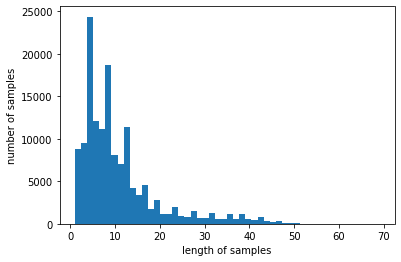

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
# 대부분의 문장의 길이가 30이하다. 문장의 길이를 적절히 설정한다.

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


# 패딩

In [ ]:
# 길이가 30이하인 샘플의 비율이 94%가량 된다. max_len을 30으로 설정한다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
word_index = tokenizer.word_index # 사전생성
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 사전 학습된 모델 로드



In [ ]:
from gensim.models import word2vec



def train_word2vec(sentence_matrix, vocabulary_inv, num_features=300, min_word_count=1, context=10):
    file_path = './data/'
    embedding_model = word2vec.Word2Vec.load(file_path+'ko.bin')
    embedding_weight = {key: embedding_model[word] if word in embedding_model else np.random.uniform(-0.25, 0.25, embedding_model.vector_size) for key, word in vocabulary_inv.items()}

    return embedding_weight

# 모델 선언, 훈련

- Dense층 추가 : ```z = tf.keras.layers.Dense(64, activation="relu")(z)```

In [ ]:
import numpy as np
import os

import tensorflow as tf
# from tensorflow import keras

os.environ['KMP_DUPLICATE_LIB_OK']='True'


model_type = "CNN-non-static"

embedding_dim = 200
filter_sizes = (3, 4, 5)
num_filters = 100
dropout = 0.5
hidden_dims = 100

batch_size = 50
num_epochs = 10
min_word_count = 1
context = 10

x_train, y_train, x_test, y_test, vocabulary_inv = X_train, y_train, X_test, y_test, reverse_word_index

sequence_length = x_test.shape[1]


embedding_weights = train_word2vec(np.vstack((x_train, x_test)), vocabulary_inv, num_features=embedding_dim, min_word_count=min_word_count, context=context)

input_shape = (sequence_length,)

model_input = tf.keras.layers.Input(shape=input_shape)

z = tf.keras.layers.Embedding(len(vocabulary_inv), embedding_dim, input_length=sequence_length, name="embedding")(model_input)

z = tf.keras.layers.Dropout(dropout)(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = tf.keras.layers.Conv1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = tf.keras.layers.MaxPooling1D(pool_size=2)(conv)
    conv = tf.keras.layers.Flatten()(conv)
    conv_blocks.append(conv)
z = tf.keras.layers.Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = tf.keras.layers.Dropout(dropout)(z)
z = tf.keras.layers.Dense(hidden_dims, activation="relu")(z)
z = tf.keras.layers.Dense(32, activation="relu")(z)
model_output = tf.keras.layers.Dense(1, activation="sigmoid")(z)

model = tf.keras.Model(model_input, model_output)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Initialize weights with word2vec

weights = np.array([v for v in embedding_weights.values()])
print("Initializing embedding layer with word2vec weights, shape", weights.shape)
embedding_layer = model.get_layer("embedding")
embedding_layer.set_weights([weights])

# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=num_epochs, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Initializing embedding layer with word2vec weights, shape (43752, 200)
Epoch 1/10
2904/2904 - 224s - loss: 0.5158 - accuracy: 0.7288 - val_loss: 0.3923 - val_accuracy: 0.8253
Epoch 2/10
2904/2904 - 220s - loss: 0.3875 - accuracy: 0.8268 - val_loss: 0.3630 - val_accuracy: 0.8414
Epoch 3/10
2904/2904 - 219s - loss: 0.3554 - accuracy: 0.8451 - val_loss: 0.3563 - val_accuracy: 0.8452
Epoch 4/10
2904/2904 - 219s - loss: 0.3348 - accuracy: 0.8566 - val_loss: 0.3464 - val_accuracy: 0.8485
Epoch 5/10
2904/2904 - 220s - loss: 0.3183 - accuracy: 0.8636 - val_loss: 0.3436 - val_accuracy: 0.8502
Epoch 6/10
2904/2904 - 218s - loss: 0.3043 - accuracy: 0.8712 - val_loss: 0.3415 - val_accuracy: 0.8502
Epoch 7/10
2904/2904 - 219s - loss: 0.2928 - accuracy: 0.8768 - val_loss: 0.3448 - val_accuracy: 0.8515
Epoch 8/10
2904/2904 - 220s - loss: 0.2827 - accuracy: 0.8812 - val_loss: 0.3449 - val_accuracy: 0.8526
Epoch 9/10
2904/2904 - 220s - loss: 0.2718 - accuracy: 0.8865 - val_loss: 0.3466 - val_accuracy: 

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3439 - accuracy: 0.8529
0.8528617024421692


```
embedding_dim = 200
filter_sizes = (3, 4, 5)
num_filters = 100
dropout = 0.5
hidden_dims = 100

batch_size = 50
num_epochs = 10
min_word_count = 1
context = 10

z = tf.keras.layers.Dropout(dropout)(z)
z = tf.keras.layers.Dense(hidden_dims, activation="relu")(z)
z = tf.keras.layers.Dense(64, activation="relu")(z)
```
바로 위 셀의 결과와 아래 셀의 결과는 같은 모델을 사용한 결과다.

같은 조건으로 다시 fit시켰을때 결과의 차이가 있어서 낮은 수치로 제출했음.

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)

1527/1527 [==============================] - 5s 3ms/step - loss: 0.3525 - accuracy: 0.8537
0.8536804914474487


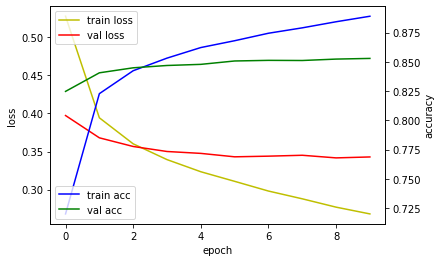

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'],'y',label='train loss')
loss_ax.plot(history.history['val_loss'],'r',label='val loss')
acc_ax.plot(history.history['accuracy'],'b',label='train acc')
acc_ax.plot(history.history['val_accuracy'],'g',label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [ ]:
# 결과 제출한 모델 저장.
model.save('./data/model(use_preprocess,batch_size50,85294,adddense(32))')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/멀캠/논문구현/Convolutional Neural Networks for Sentence Classification/data/model(use_preprocess,batch_size50,85294,adddense(32))/assets


## [모델 다운로드](https://drive.google.com/drive/folders/1rMNhAfu2YcsAN8uoK37JIWOqiPmuOKKn?usp=sharing)

In [ ]:
# 저장한 모델 로드
from tensorflow import keras
model = keras.models.load_model('./data/model(use_preprocess,batch_size50,85294,adddense(32))')
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(test_accuracy)